In [12]:
import gym
import time
import torch as T
import torch.nn as nn
from supersuit import frame_stack_v1, color_reduction_v0, frame_skip_v0, max_observation_v0
import torchvision.models as models
from torchvision import transforms
from einops import rearrange
import matplotlib.pyplot as plt
import torch.nn.functional as F
import kornia as K

In [2]:
def crop_bottom(x):
    return x[:,:,:172,:]

In [3]:
def preprocess(img):
    img = T.from_numpy(img).unsqueeze(0).float()
    img = rearrange(img, 'b h w c -> b c h w')
    img = crop_bottom(img)
    
    return img

In [4]:
def plot_state(state):
    fig = plt.figure(figsize=(12,6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(state[0][0], cmap='gray');
    fig.add_subplot(1, 2, 2)
    plt.imshow(state[0][1], cmap='gray');
    plt.show()

In [6]:
env = gym.make('MsPacman-v4')
env = color_reduction_v0(env, 'full')
env = max_observation_v0(env, 4)
env = frame_skip_v0(env, FRAMES_TO_SKIP)
env = frame_stack_v1(env, FRAMES_TO_STACK)

In [7]:
FRAMES_TO_STACK = 2
FRAMES_TO_SKIP = 4
NUM_ACTIONS = gym.spaces.utils.flatdim(env.action_space)

In [8]:
done = False
s = env.reset()
i = 0
rewards = []
render = False

while not done:
    if render:
        env.render()
        time.sleep(1/60)
    action = env.action_space.sample()
    s_, r, done, _ = env.step(action)

    i += 1
    rewards.append(r)
    if i == 100: break
    
env.close()

In [9]:
s = preprocess(s)

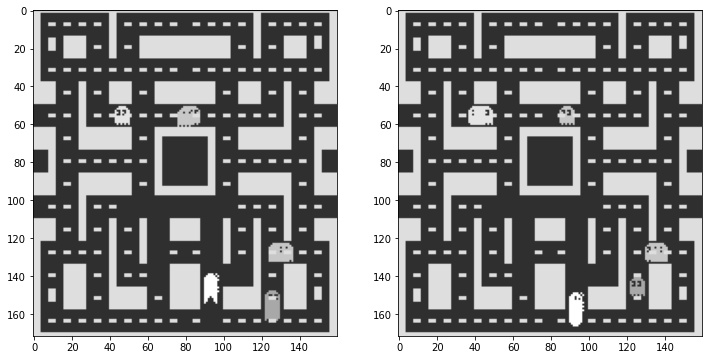

In [10]:
plot_state(s)

In [11]:
class ContrastiveLearner(nn.Module):
    def __init__(self, num_actions, frame_stack, resnet_dim=2048, project_dim=2048):
        super(ContrastiveLearner, self).__init__()
        
        self.encoder = models.resnet50(pretrained=False, num_classes=resnet_dim)
        self.encoder.conv1 = nn.Conv2d(frame_stack, 64, (7, 7), (2, 2), (3, 3), bias=False)
        self.layer_norm = nn.LayerNorm(resnet_dim)
        
        self.project_head = nn.Sequential(
            nn.Linear(resnet_dim, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, project_dim)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.layer_norm(x)
        x = T.tanh(x)
        
        return x
    
    def encode(self, x):
        return self.forward(x)
    
    def project(self, x):
        x = self.forward(x)
        x = self.project_head(x)
        
        return x

In [ ]:
def cosine_sim(a, b):
    return a @ b / (T.linalg.norm(a) * T.linalg.norm(b))

In [16]:
class DataAugment(nn.Module):
    def __init__(self):
        super().__init__()

        self.jitter = K.augmentation.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        
        self.flip = nn.Sequential(
            K.augmentation.RandomHorizontalFlip(p=0.5),
            K.augmentation.RandomVerticalFlip(p=0.5)
        )

        # self.rotate = K.augmentation.RandomRotation(degrees=[90, 180, 270])
    
    @T.no_grad()
    def forward(self, x):
        x = self.jitter(x)
        x = self.flip(x)
        
        return x

In [18]:
s.shape

torch.Size([1, 2, 172, 160])

In [19]:
dm = DataAugment()

In [21]:
#dm(s)